# 时间序列分析第八次作业
使用SETAR模型和ARIMA模型，并对比两模型在预测上的效果，对比发现：在这组数据下SETAR模型效果显然优于ARIMA模型

姓名：欧阳瑞志、班级：统计22、学号：220403102

## 一、数据导入
使用1952年到2000年中国GDP数据  
参考文献：[1]袁军.SETAR模型在GDP预测中的应用[J].统计与决策,2007,(10):18-20.

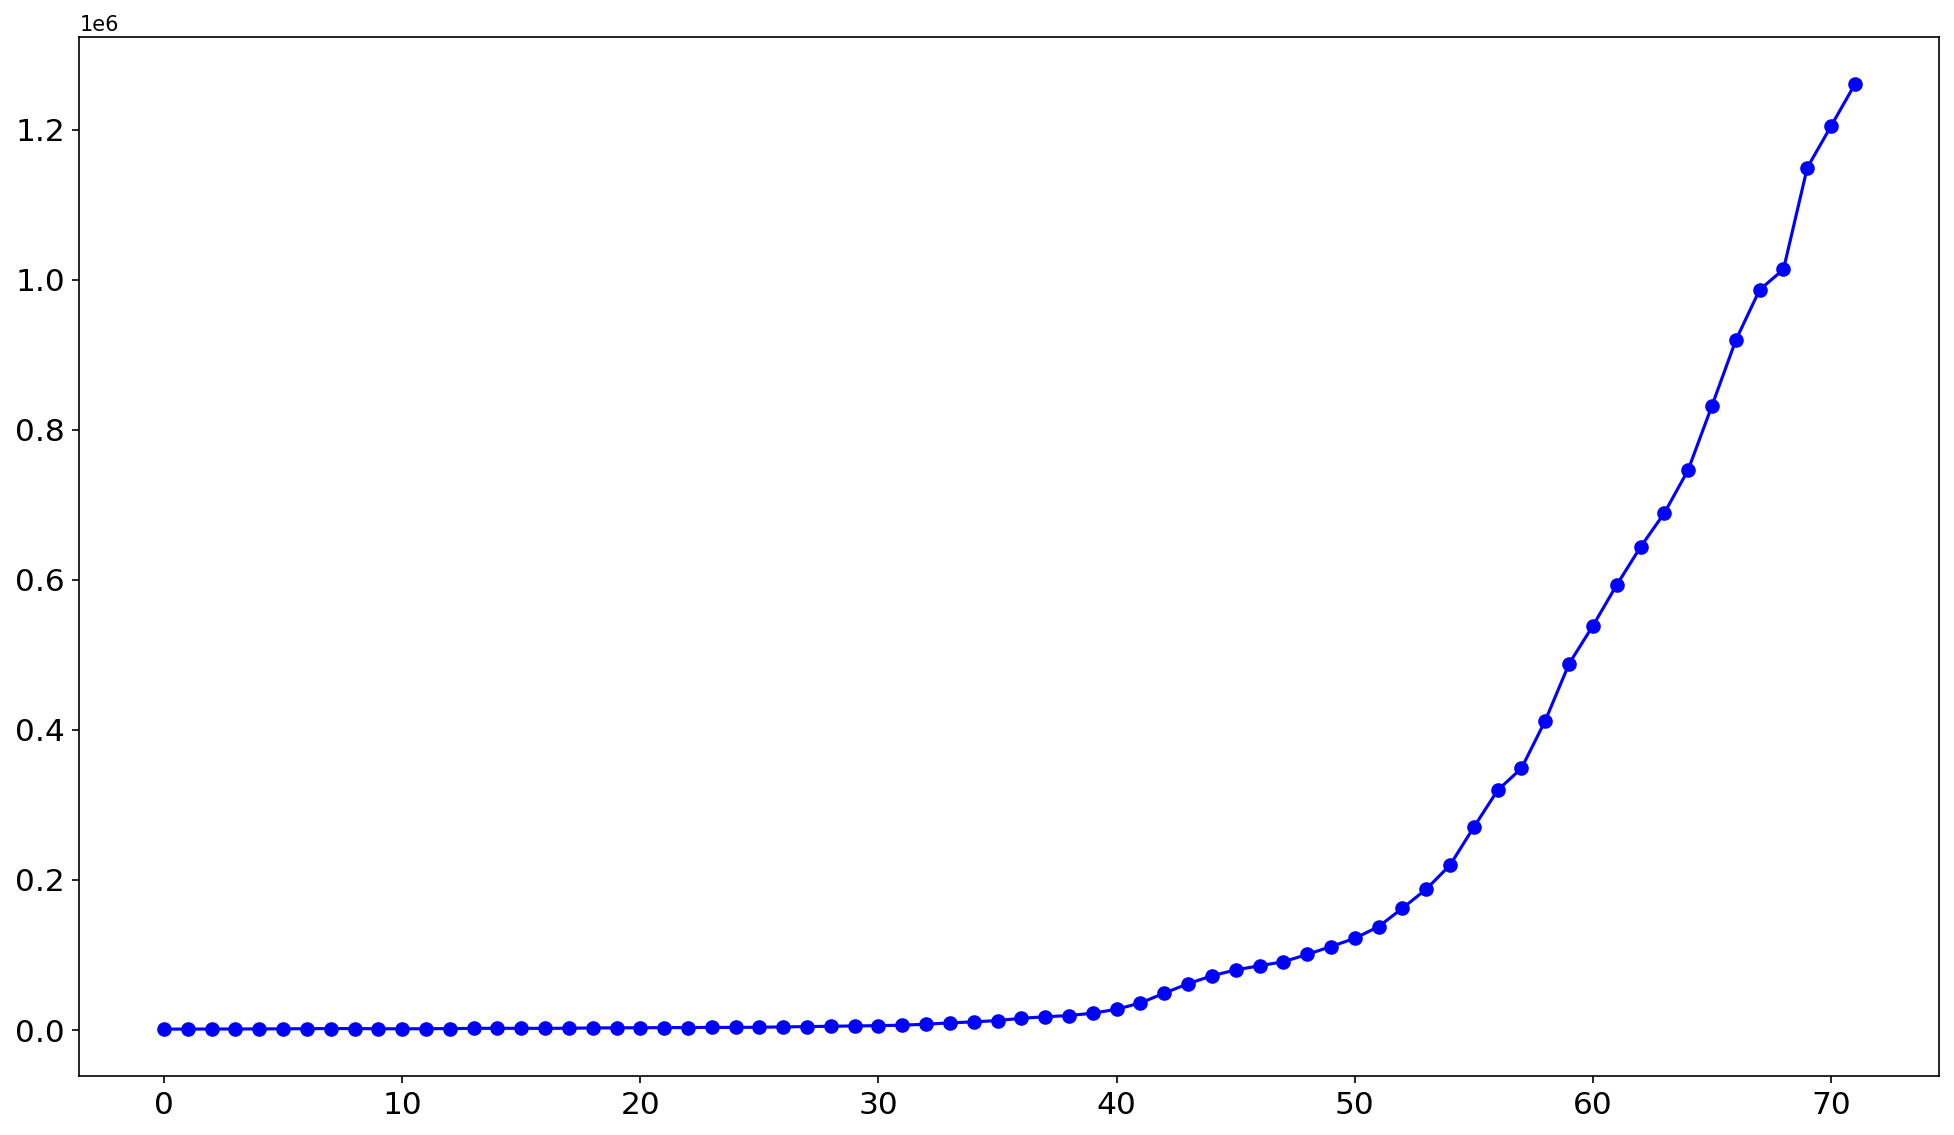

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

## 数据导入 
# 使用 1952年 到 2000年 中国GDP数据
# 参考文献：[1]袁军.SETAR模型在GDP预测中的应用[J].统计与决策,2007,(10):18-20.
GDP = [679.1, 824.4, 859.8, 911.6, 1030.7, 1071.4, 1312.3, 1447.5, 1470.1, 1232.3, 1162.2, 1248.3, 1469.9, 1734.0, 1888.7, 
       1794.2, 1744.1, 1962.2, 2279.7, 2456.9, 2552.4, 2756.2, 2827.7, 3039.5, 2988.6, 3250.0, 3678.7, 4100.5, 4587.6, 4935.8, 
       5373.4, 6020.9, 7278.5, 9098.9, 10376.2, 12174.6, 15180.4, 17179.7, 18872.9, 22005.6, 27194.5, 35673.2, 48637.5, 61339.9, 
       71813.6, 79715.0, 85195.5, 90564.4, 100280.1, 110863.1, 121717.4, 137422.0, 161840.2, 187318.9, 219438.5, 270092.3, 319244.6, 
       348517.7, 412119.3, 487940.2, 538580.0, 592963.2, 643563.1, 688858.2, 746395.1, 832035.9, 919281.1, 986515.2, 1013567.0, 
       1149237.0, 1204724.0, 1260582.1]

# 绘制序列图做平稳性检验
plt.figure(figsize=(16, 9), dpi=150)
plt.plot(GDP, linestyle='-', color='b', marker='o', markerfacecolor='b')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='原始数据序列图.png')

## 二、对数变换
观察到数据存在着明显的指数趋势，先对数变换消除这种指数趋势

均值：9.961933918438476，方差：6.036001282384937


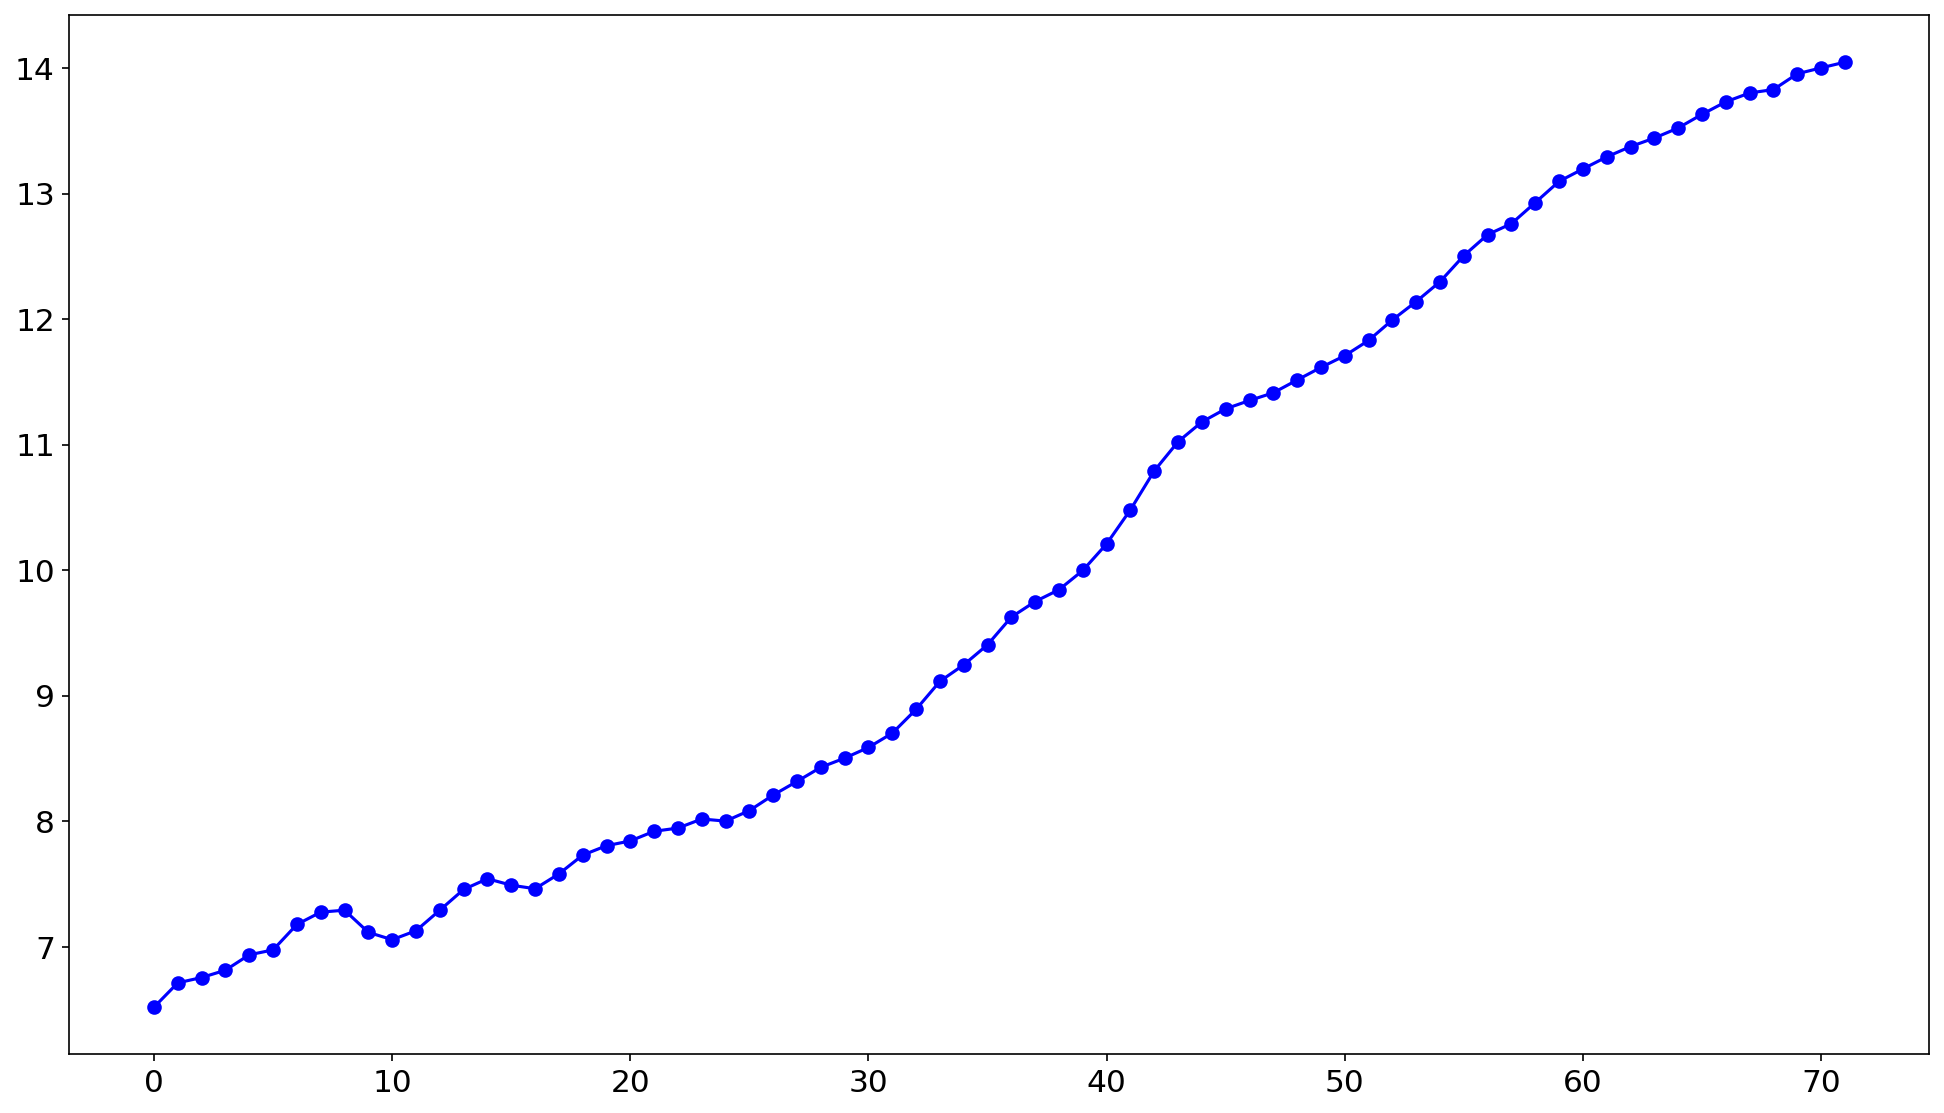

In [4]:
## 数据变换与平稳性检验
# 对数变换
data = np.log(GDP)

# 计算均值和方差
mean = np.mean(data)
variance = np.var(data)
print(f'均值：{mean}，方差：{variance}')

# 绘制序列图做平稳性检验
plt.figure(figsize=(16, 9), dpi=150)
plt.plot(data, linestyle='-', color='b', marker='o', markerfacecolor='b')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='数据变换后的序列图.png')

## 三、数据差分与平稳性检验
### 3.1 一阶差分
对数变换后数据仅剩下线性趋势，通过一阶差分消除线性趋势

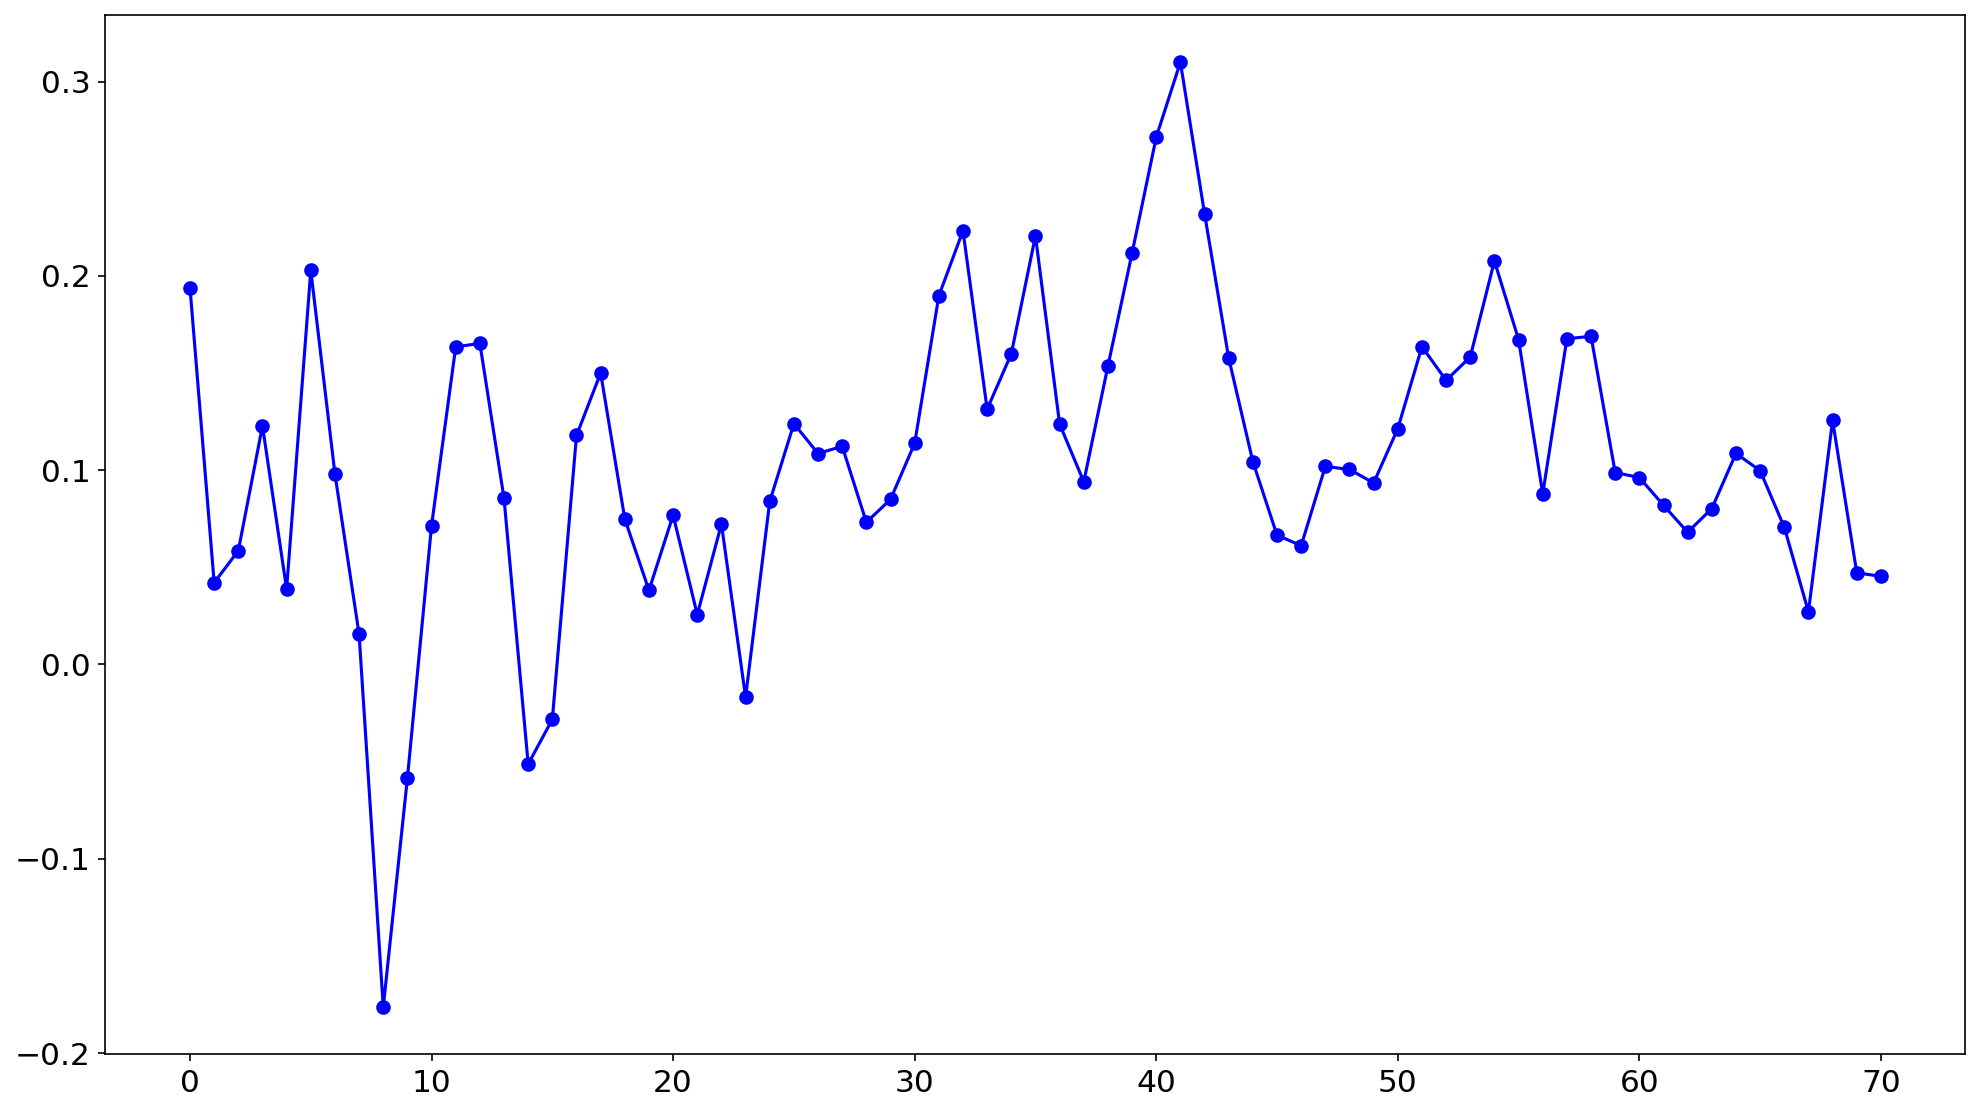

In [5]:
## 数据差分
# 一阶差分
first_order_diff = np.diff(data)

# 绘制一阶差分后的序列图
plt.figure(figsize=(16, 9), dpi=150)
plt.plot(first_order_diff, linestyle='-', color='b', marker='o', markerfacecolor='b')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='一阶差分后的的序列图.png')

### 3.2 ADF检验
原假设$$H0:序列非平稳$$
备择假设$$H1:序列平稳$$

In [6]:
# 对一阶差分后的数据做 ADF 检验
result_first_order = adfuller(first_order_diff , autolag='AIC')
print(f'一阶差分后 ADF 检验统计量：{result_first_order[0]}')
print(f'p 值：{result_first_order[1]}')
print(f'临界值（1%）：{result_first_order[4]["1%"]}')
print(f'临界值（5%）：{result_first_order[4]["5%"]}')
print(f'临界值（10%）：{result_first_order[4]["10%"]}')

if result_first_order[1] < 0.05:
    print('ADF检验下一阶差分数据是平稳的。')
else:
    print('ADF检验下一阶差分数据不是平稳的。')

一阶差分后 ADF 检验统计量：-3.8801820037774446
p 值：0.0021856355718467813
临界值（1%）：-3.530398990560757
临界值（5%）：-2.9050874099328317
临界值（10%）：-2.5900010121107266
ADF检验下一阶差分数据是平稳的。


### 3.3 PP检验
原假设$$H0:时间序列包含单位根$$
备择假设$$H1:时间序列为弱平稳$$

In [7]:
# 对一阶差分后的数据做 PP 检验
pp = PhillipsPerron(first_order_diff)
print(pp.summary().as_text())

p_value = pp.pvalue

if p_value < 0.05:
    print("拒绝原假设，PP检验下一阶差分后的数据是平稳数据。")
else:
    print("不拒绝原假设，PP检验下一阶差分后的数据是非平稳数据。")

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -4.505
P-value                         0.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.53 (1%), -2.90 (5%), -2.59 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
拒绝原假设，PP检验下一阶差分后的数据是平稳数据。


## 四、纯随机性检验
已经判断差分后的序列为平稳性数据，进一步判断是否为白噪声数据，采用LB检验。  
原假设：$$H_0: \rho_1=\rho_2=\cdots=\rho_m=0, \forall m \geq 1$$  
备择假设：$$H_1: \rho_k \neq 0,  \forall m \geq 1, k \leq m$$  
LB统计量：$$LB=n(n+2) \sum_{k=1}^m\left(\frac{\hat{\rho}_k^2}{n-k}\right) \sim \chi^2(m)$$
从结果上来看，p值小于0.05，拒绝原假设，认为这一组序列为非白噪声序列，不具有纯随机性。

In [8]:
## 纯随机检验
LB = acorr_ljungbox(first_order_diff, lags=range(1, 15), boxpierce=True, return_df=True)
print(LB)

      lb_stat     lb_pvalue    bp_stat     bp_pvalue
1   24.585565  7.108221e-07  23.575199  1.201258e-06
2   27.766722  9.344004e-07  26.582046  1.689593e-06
3   27.827113  3.948523e-06  26.638301  7.010208e-06
4   28.049387  1.218874e-05  26.842305  2.139279e-05
5   31.293452  8.196848e-06  29.775296  1.632910e-05
6   38.961251  7.283874e-07  36.602788  2.104345e-06
7   44.777411  1.510618e-07  41.701887  5.934401e-07
8   45.135445  3.468724e-07  42.010875  1.347896e-06
9   45.142086  8.684720e-07  42.016516  3.263782e-06
10  45.525048  1.748152e-06  42.336525  6.532162e-06
11  45.965774  3.278696e-06  42.698766  1.225332e-05
12  46.065446  6.760498e-06  42.779322  2.460709e-05
13  46.968831  9.779889e-06  43.497080  3.717004e-05
14  48.018569  1.305295e-05  44.316739  5.262732e-05


## 五、SETAR建模
自激励门限自回归模型（SETAR）  
SETAR模型的关键在于其关键参数为$d$表示门限变量个数，在此为了研究的方便，选择状态数为2的模型:$$SETAR(2,p_1,p_2)$$
为了研究的方便，对于两个不同状态的模型，仅建立AR模型，不考虑更复杂的ARMA模型，因此另外的关键参数为$p_1$和$p_2$，为两个不同状态的AR模型的参数

### 5.1 门限值的确定
采用黄金分割法，遍历搜索最优解，判断模型使用信息准则AIC判断

In [9]:
## 模型识别-SETAR(x,p,q)
# 首先确定门限值
def calculate_AIC(threshold, data):
    state_1_data = data[data <= threshold]
    state_2_data = data[data > threshold]
    # 简单点，仅拟合AR模型
    model_state_1 = SARIMAX(state_1_data, order=(1, 0, 0)).fit(disp=False)
    model_state_2 = SARIMAX(state_2_data, order=(1, 0, 0)).fit(disp=False)
    # 综合考虑AIC信息准则判断
    AIC_1 = model_state_1.aic
    AIC_2 = model_state_2.aic
    return AIC_1 + AIC_2

a = first_order_diff.min()
b = first_order_diff.max()
print("最小值:", a)
print("最大值:", b)
# 通过黄金分割法搜索最优门限值
phi = (np.sqrt(5)-1)/2

x1 = a+(1 - phi)*(b - a)
x2 = a+phi*(b - a)

AIC_x1 = calculate_AIC(x1, first_order_diff)
AIC_x2 = calculate_AIC(x2, first_order_diff)

precision = 0.01 # 精度

while (b - a) > precision:
    if AIC_x1 < AIC_x2:
        b = x2
        x2 = x1
        AIC_x2 = AIC_x1
        x1 = a+(1 - phi)*(b - a)
        AIC_x1 = calculate_AIC(x1, first_order_diff)
    else:
        a = x1
        x1 = x2
        AIC_x1 = AIC_x2
        x2 = a+phi*(b - a)
        AIC_x2 = calculate_AIC(x2, first_order_diff)
threshold_value = (a + b)/2

print("确定的门限值:", threshold_value)

最小值: -0.17644808372584286
最大值: 0.3099951317217453
确定的门限值: 0.10028153616487245


### 5.2 不同状态对应模型的滞后阶数的确定

In [10]:
# 确定滞后阶数
# 定义计算 AIC 的函数
def calculate_AIC_with_lags(threshold, data, p1, p2):
    state_1_data = data[data <= threshold]
    state_2_data = data[data > threshold]
    # 简单点，仅拟合AR模型
    model_state_1 = SARIMAX(state_1_data, order=(p1, 0, 0)).fit(disp=False)
    model_state_2 = SARIMAX(state_2_data, order=(p2, 0, 0)).fit(disp=False)
    # 综合考虑AIC信息准则判断
    AIC_1 = model_state_1.aic
    AIC_2 = model_state_2.aic

    return AIC_1 + AIC_2

# 滞后阶数的搜索范围
p_range = range(1, 6) 
q_range = range(1, 6)

# 遍历搜索解
min_AIC = float('inf')
optimal_p1 = None
optimal_p2 = None

for p1 in p_range:
    for p2 in p_range:
        AIC_value = calculate_AIC_with_lags(threshold_value, first_order_diff, p1, p2)
        if AIC_value < min_AIC:
            min_AIC = AIC_value
            optimal_p1 = p1
            optimal_p2 = p2

print("最优滞后阶数p1:", optimal_p1)
print("最优滞后阶数p2:", optimal_p2)

最优滞后阶数p1: 4
最优滞后阶数p2: 1


### 5.3 模型的拟合与参数检验

In [13]:
## 模型识别为SETAR(2,4,1)
## 构建SETAR模型
threshold = threshold_value
state_1_data = first_order_diff[first_order_diff <= threshold]
state_2_data = first_order_diff[first_order_diff > threshold]
model_state_1 = SARIMAX(state_1_data, order=(optimal_p1, 0, 0))
model_state_2 = SARIMAX(state_2_data, order=(optimal_p2, 0, 0))

# 拟合模型
result_state_1 = model_state_1.fit(disp=False)
result_state_2 = model_state_2.fit(disp=False)

print("状态1模型拟合结果：")
print(result_state_1.summary().tables[1])
print("状态2模型拟合结果：")
print(result_state_2.summary().tables[1])

状态1模型拟合结果：
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5110      0.227      2.252      0.024       0.066       0.956
ar.L2         -0.1264      0.174     -0.725      0.469      -0.468       0.215
ar.L3          0.0683      0.200      0.341      0.733      -0.324       0.461
ar.L4          0.3911      0.215      1.816      0.069      -0.031       0.813
sigma2         0.0024      0.001      4.738      0.000       0.001       0.003
状态2模型拟合结果：
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9583      0.042     22.650      0.000       0.875       1.041
sigma2         0.0023      0.001      2.967      0.003       0.001       0.004


通过模型的拟合与参数检验，确定$SETAR(2,4,1)$模型为：
$$
\begin{cases}
X_t = 0.5110X_{t-1} + 0.3911X_{t-4} + \epsilon_{1t}, & X_t \leq 0.10028153616487245 \\
X_t = 0.9583X_{t-1} + \epsilon_{2t}, & X_t > 0.10028153616487245
\end{cases}
$$

## 六、SETAR模型的预测
怎么statsmodels里没有SETAR的库呀，纯手撸，真的晕，可以调用stata嘛...  
没有库，不会还原成原始数据，就直接预测平稳的差分数据了，见谅

状态1模型预测结果：
       mean   mean_se  90%lower  90%upper  95%lower  95%upper
0  0.046655  0.049253 -0.034360  0.127670 -0.049880  0.143190
1  0.031914  0.055310 -0.059064  0.122891 -0.076493  0.140320
2  0.031949  0.055707 -0.059680  0.123579 -0.077234  0.141133
3  0.033206  0.055822 -0.058612  0.125025 -0.076202  0.142615
状态2模型拟合结果：
       mean   mean_se  90%lower  90%upper  95%lower  95%upper
0  0.120388  0.047561  0.042157  0.198618  0.027170  0.213605
1  0.115371  0.065875  0.007017  0.223726 -0.013740  0.244483
2  0.110564  0.079040 -0.019446  0.240574 -0.044352  0.265480
3  0.105957  0.089441 -0.041160  0.253073 -0.069343  0.281257
模型拟合结果： [0.04665508115371489, 0.11537140152265139, 0.03194942874035436, 0.10595685815155831]
90%lower预测区间： [-0.03435954246633584, 0.007017296199654355, -0.05968037581266861, -0.04115972027734799]
90%upper预测区间： [0.1276697047737656, 0.22372550684564843, 0.12357923329337733, 0.2530734365804646]
95%lower预测区间： [-0.049879797035207396, -0.013740478422395827, -0.0

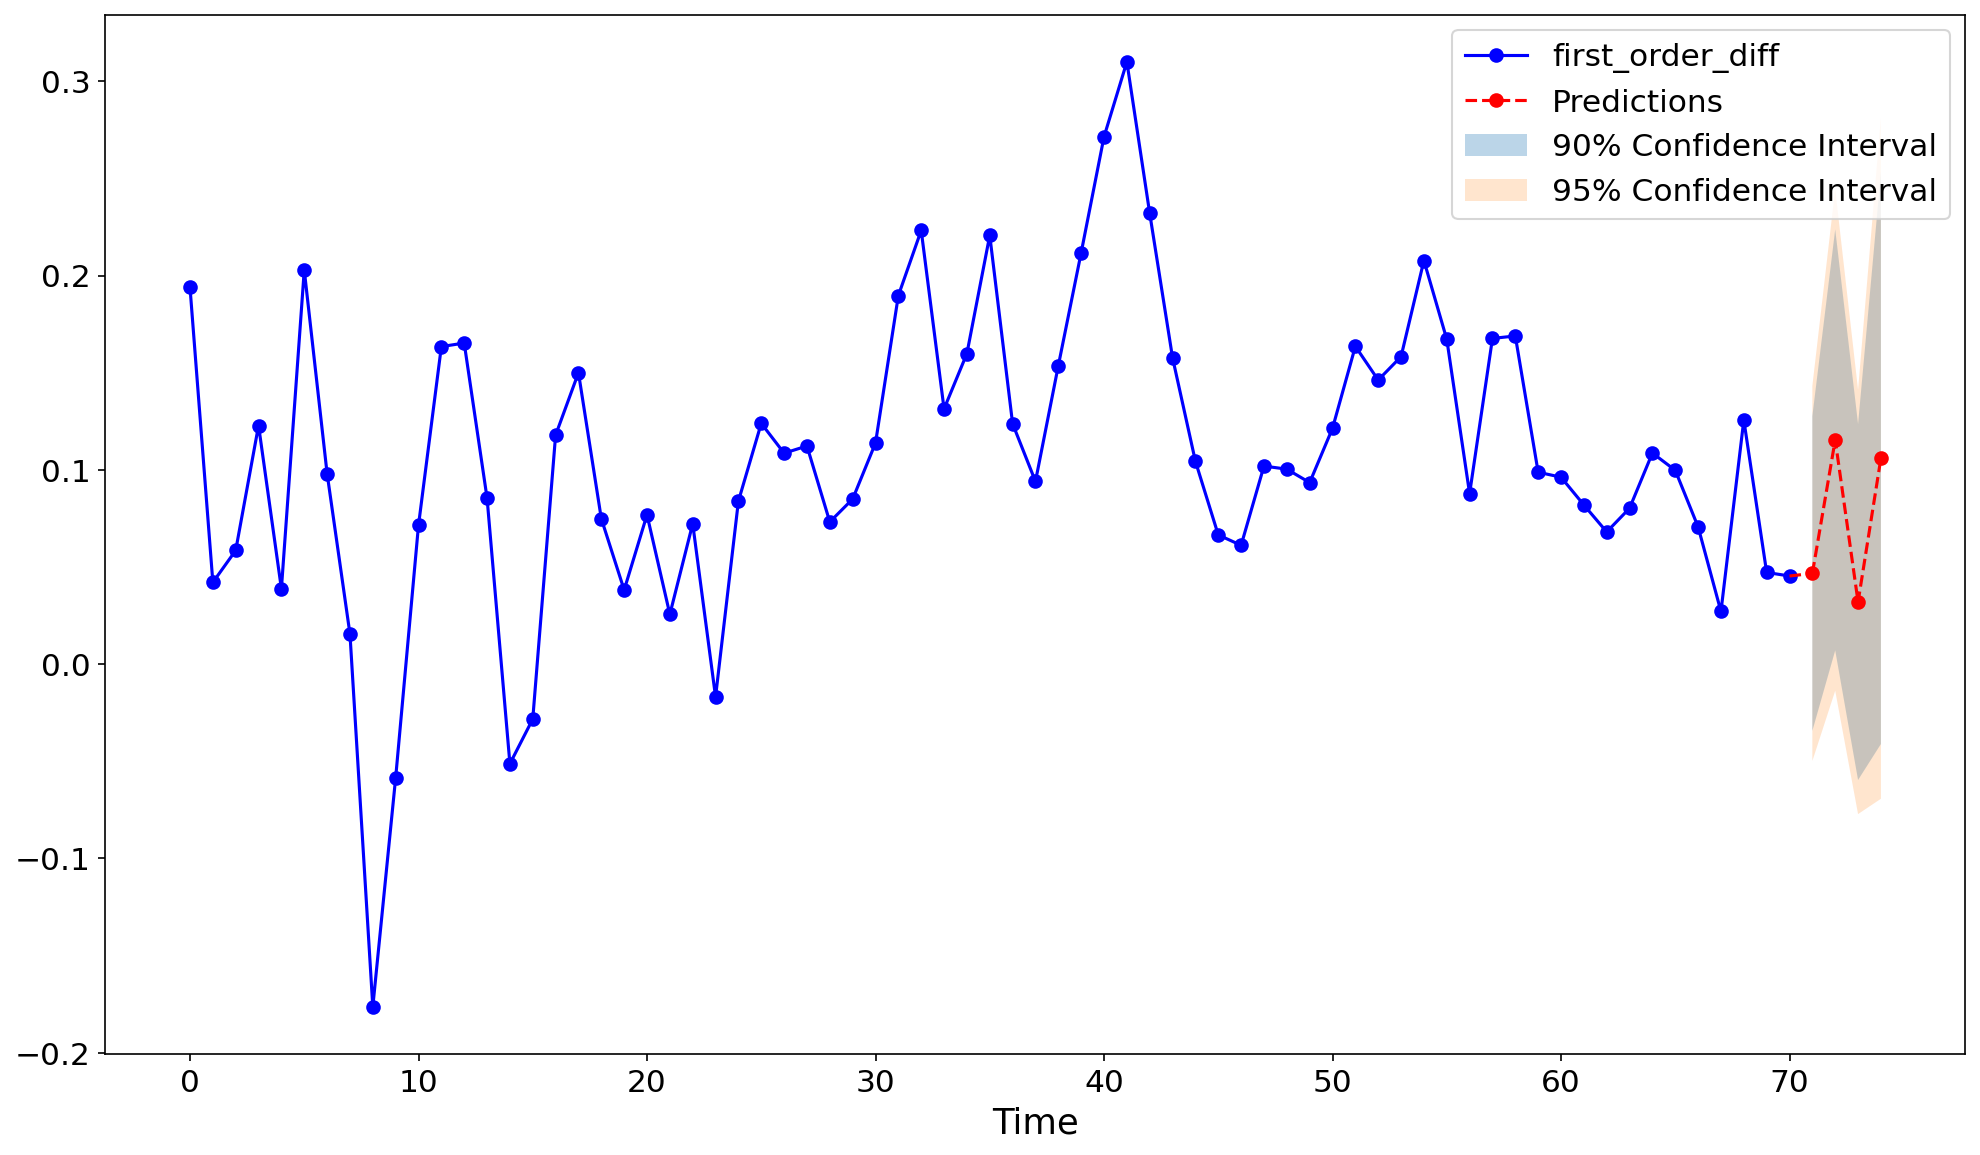

In [14]:
## 预测未来三个数据
# 预测步数
steps = 4

# 进行预测
forecast_state_1 = result_state_1.get_forecast(steps)
forecast_state_2 = result_state_2.get_forecast(steps)

# 获取预测结果的置信区间和预测值
confint1=forecast_state_1.summary_frame(alpha=0.10)
confint2=forecast_state_1.summary_frame(alpha=0.05).iloc[:,2:]
confint1.columns=["mean","mean_se","90%lower","90%upper"]
confint2.columns=["95%lower","95%upper"]
confint_model_1 = pd.concat([confint1,confint2],axis=1,ignore_index=False)
print("状态1模型预测结果：")
print(confint_model_1)
confint1=forecast_state_2.summary_frame(alpha=0.10)
confint2=forecast_state_2.summary_frame(alpha=0.05).iloc[:,2:]
confint1.columns=["mean","mean_se","90%lower","90%upper"]
confint2.columns=["95%lower","95%upper"]
confint_model_2 = pd.concat([confint1,confint2],axis=1,ignore_index=False)
print("状态2模型拟合结果：")
print(confint_model_2)

# 假设数据在不同状态下是交替出现的，简单交替合并预测结果
forecast_combined = []
forecast_combined_90_lower = []
forecast_combined_90_upper = []
forecast_combined_95_lower = []
forecast_combined_95_upper = []

for i in range(steps):
    if i % 2 == 0:
        forecast_combined.append(forecast_state_1.predicted_mean[i])
        forecast_combined_90_lower.append(confint_model_1.loc[i, "90%lower"])
        forecast_combined_90_upper.append(confint_model_1.loc[i, "90%upper"])
        forecast_combined_95_lower.append(confint_model_1.loc[i, "95%lower"])
        forecast_combined_95_upper.append(confint_model_1.loc[i, "95%upper"])
    else:
        forecast_combined.append(forecast_state_2.predicted_mean[i])
        forecast_combined_90_lower.append(confint_model_2.loc[i, "90%lower"])
        forecast_combined_90_upper.append(confint_model_2.loc[i, "90%upper"])
        forecast_combined_95_lower.append(confint_model_2.loc[i, "95%lower"])
        forecast_combined_95_upper.append(confint_model_2.loc[i, "95%upper"])

print("模型拟合结果：", forecast_combined)
print("90%lower预测区间：", forecast_combined_90_lower)
print("90%upper预测区间：", forecast_combined_90_upper)
print("95%lower预测区间：", forecast_combined_95_lower)
print("95%upper预测区间：", forecast_combined_95_upper)

plt.figure(figsize=(16, 9), dpi=150)
plt.plot(range(len(first_order_diff)), first_order_diff, linestyle='-', color='b', marker='o', markerfacecolor='b', label='first_order_diff')
plt.plot(range(len(first_order_diff), len(first_order_diff) + len(forecast_combined)), forecast_combined, linestyle='--', color='r', marker='o', markerfacecolor='r', label='Predictions')
plt.fill_between(range(len(first_order_diff), len(first_order_diff) + len(forecast_combined)), forecast_combined_90_lower, forecast_combined_90_upper, alpha=0.3, label='90% Confidence Interval')
plt.fill_between(range(len(first_order_diff), len(first_order_diff) + len(forecast_combined)), forecast_combined_95_lower, forecast_combined_95_upper, alpha=0.2, label='95% Confidence Interval')
last_data_index = len(first_order_diff) - 1
last_pred_index = len(first_order_diff)
plt.plot([last_data_index, last_pred_index], [first_order_diff[last_data_index], forecast_combined[last_pred_index-len(first_order_diff)]], linestyle='--', color='r')
plt.xlabel('Time', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig(fname='SETAR一阶差分数据预测结果.png')

## 七、ARIMA建模
### 7.1 模型识别
直接auto_arima快速识别了，比较信息准则AIC

In [15]:
# 模型对比-ARIMA
# 识别模型
series = pd.Series(first_order_diff)
model = auto_arima(series, seasonal= False, trace=True)
print(f"自动识别的阶数：(p, d, q) = {model.order}")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-180.590, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-85.238, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-175.816, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-135.008, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-180.883, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-157.219, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-173.980, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-160.105, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-172.145, Time=0.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-179.887, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-186.050, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-188.050, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-183.989, Time=0.03 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : A

识别模型为$$ARIMA(0,0,2)$$
### 7.2 模型的拟合与参数检验

In [18]:
# 识别模型为ARIMA(0,0,2)

# 拟合模型
mod = sm.tsa.statespace.SARIMAX(first_order_diff, order=(0,0,2))
res = mod.fit(disp=False) 
print(res.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9673      0.099      9.800      0.000       0.774       1.161
ma.L2          0.5873      0.127      4.624      0.000       0.338       0.836
sigma2         0.0058      0.001      5.550      0.000       0.004       0.008


识别模型的参数检验通过，$ARIMA(0,0,2)$具体为：
$$X_t = 0.9673\epsilon_{t-1} + 0.5873\epsilon_{t-2}$$

## 7.3 均值模型的整体效果检验

残差序列： [ 0.19388746 -0.0884898   0.08947458  0.08229327 -0.08501842  0.23904518
 -0.08434985 -0.04167194 -0.08738815  0.05007308  0.07417277  0.0623933
  0.06142685 -0.01055396 -0.07718419  0.05252644  0.11234034  0.01046769
 -0.00124385  0.03318938  0.04544536 -0.03784045  0.08214214 -0.07412016
  0.10730389  0.06364066 -0.01603019  0.09037759 -0.0048498   0.03655803
  0.08126165  0.08961297  0.08882074 -0.00718525  0.11462246  0.11399902
 -0.05386625  0.0791511   0.10864309  0.06014152  0.14940342  0.13015586
  0.01839055  0.06341291  0.03224376 -0.00194129  0.04405344  0.06043333
  0.01599888  0.04243732  0.0709087   0.07003934  0.03680901  0.08151968
  0.10721968  0.01560334  0.00966762  0.14910844  0.01896965 -0.00717837
  0.09199894 -0.00288687  0.01677634  0.06568737  0.03522831  0.02706148
  0.02372045 -0.01178579  0.12309169 -0.06499239  0.03589776]
      lb_stat  lb_pvalue    bp_stat  bp_pvalue
2    5.860219   0.053391   5.619253   0.060227
7   13.992039   0.051323  13.063108 

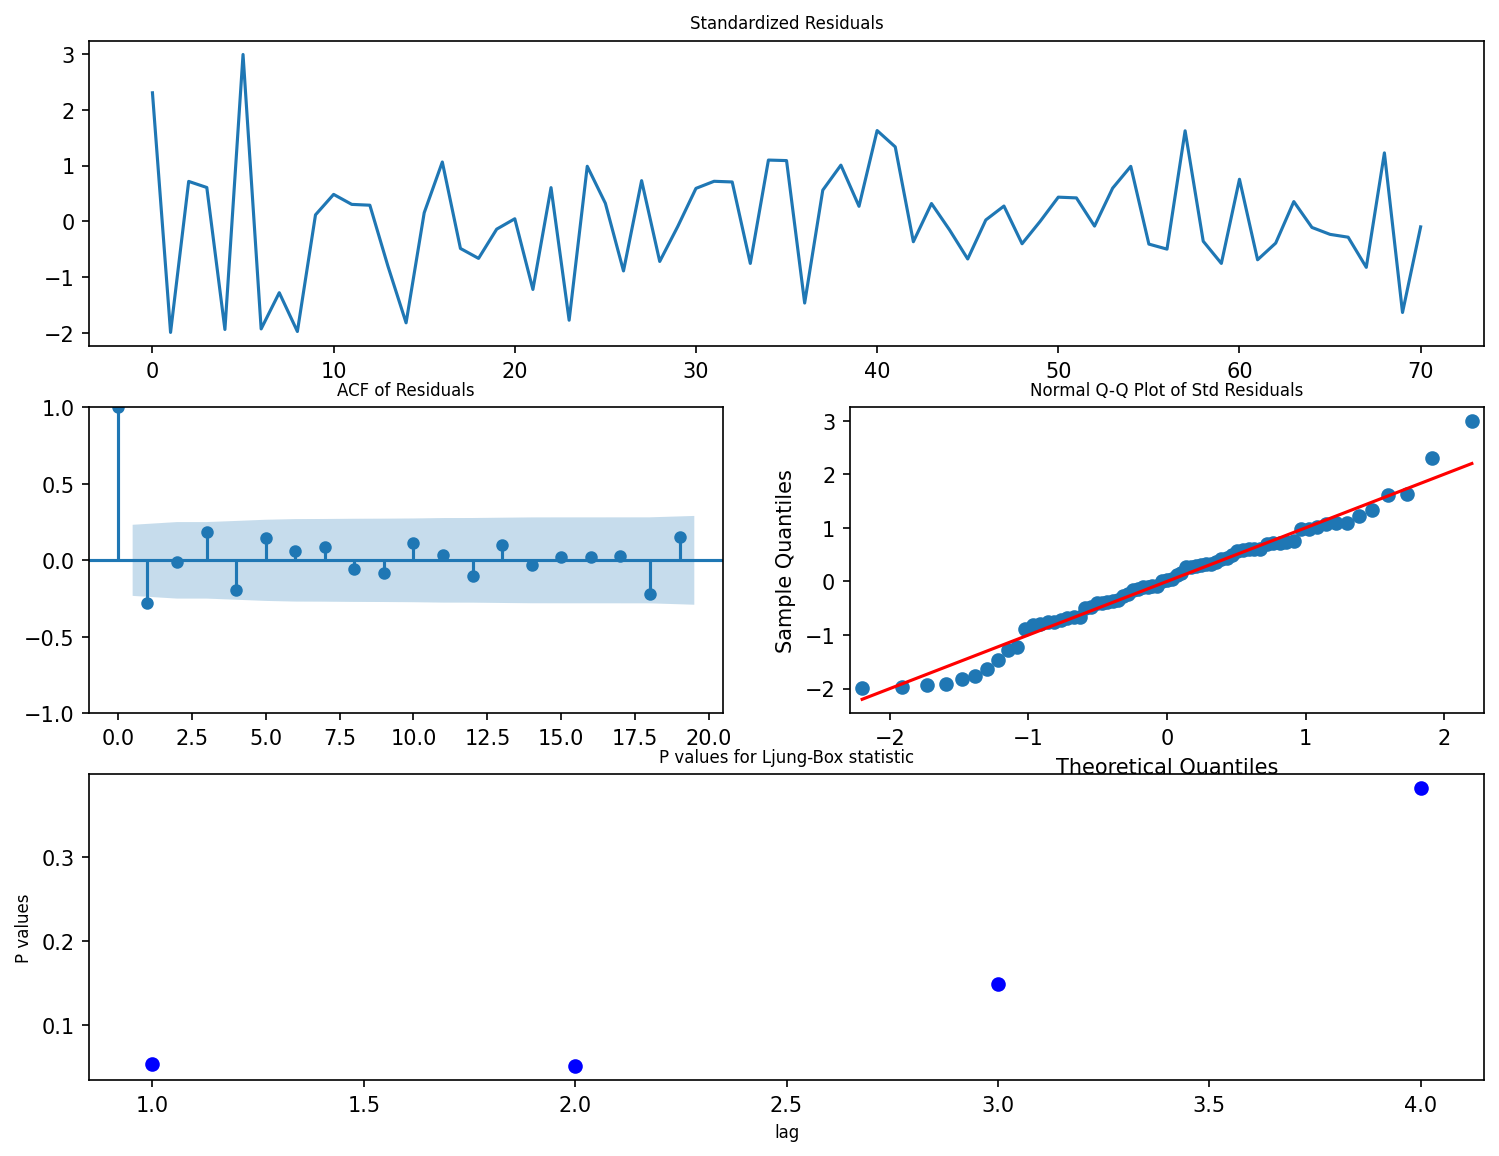

In [23]:
## 整体效果检验
# 计算残差序列
residuals = res.resid

# 输出残差序列
print("残差序列：", residuals)

# 检验残差序列为白噪声
LB = acorr_ljungbox(residuals, lags=(2,7,12,17), boxpierce=True, return_df=True)
print(LB)

resid_sd = (residuals-np.mean(residuals))/np.std(residuals)
fig = plt.figure(figsize=(12,9),dpi=150)  
ax1 = fig.add_subplot(311)  
ax1.plot(resid_sd);plt.title('Standardized Residuals', fontsize=8)  

ax2 = fig.add_subplot(323)  
plot_acf(residuals, ax=ax2)
plt.title('ACF of Residuals', fontsize=8)  

ax3 = fig.add_subplot(324)  
sm.qqplot(resid_sd, fit=True, line="s",ax=ax3)  
plt.title('Normal Q-Q Plot of Std Residuals', fontsize=8)  

lags = np.arange(1,5)
LB_p = LB.lb_pvalue
ax4 = fig.add_subplot(313)  
ax4.scatter(lags,LB_p,color="blue")
plt.xlabel(xlabel="lag", fontsize=8)  
plt.ylabel(ylabel="P values", fontsize=8)  
plt.title('P values for Ljung-Box statistic', fontsize=8)   
plt.savefig(fname='整体效果检验.png')

## 八、ARIMA模型的预测

       mean   mean_se  90%lower  90%upper  95%lower  95%upper
0 -0.003447  0.075961 -0.128392  0.121499 -0.152328  0.145435
1  0.021083  0.105684 -0.152751  0.194917 -0.186053  0.228219
2  0.000000  0.114714 -0.188688  0.188688 -0.224835  0.224835
3  0.000000  0.114714 -0.188688  0.188688 -0.224835  0.224835


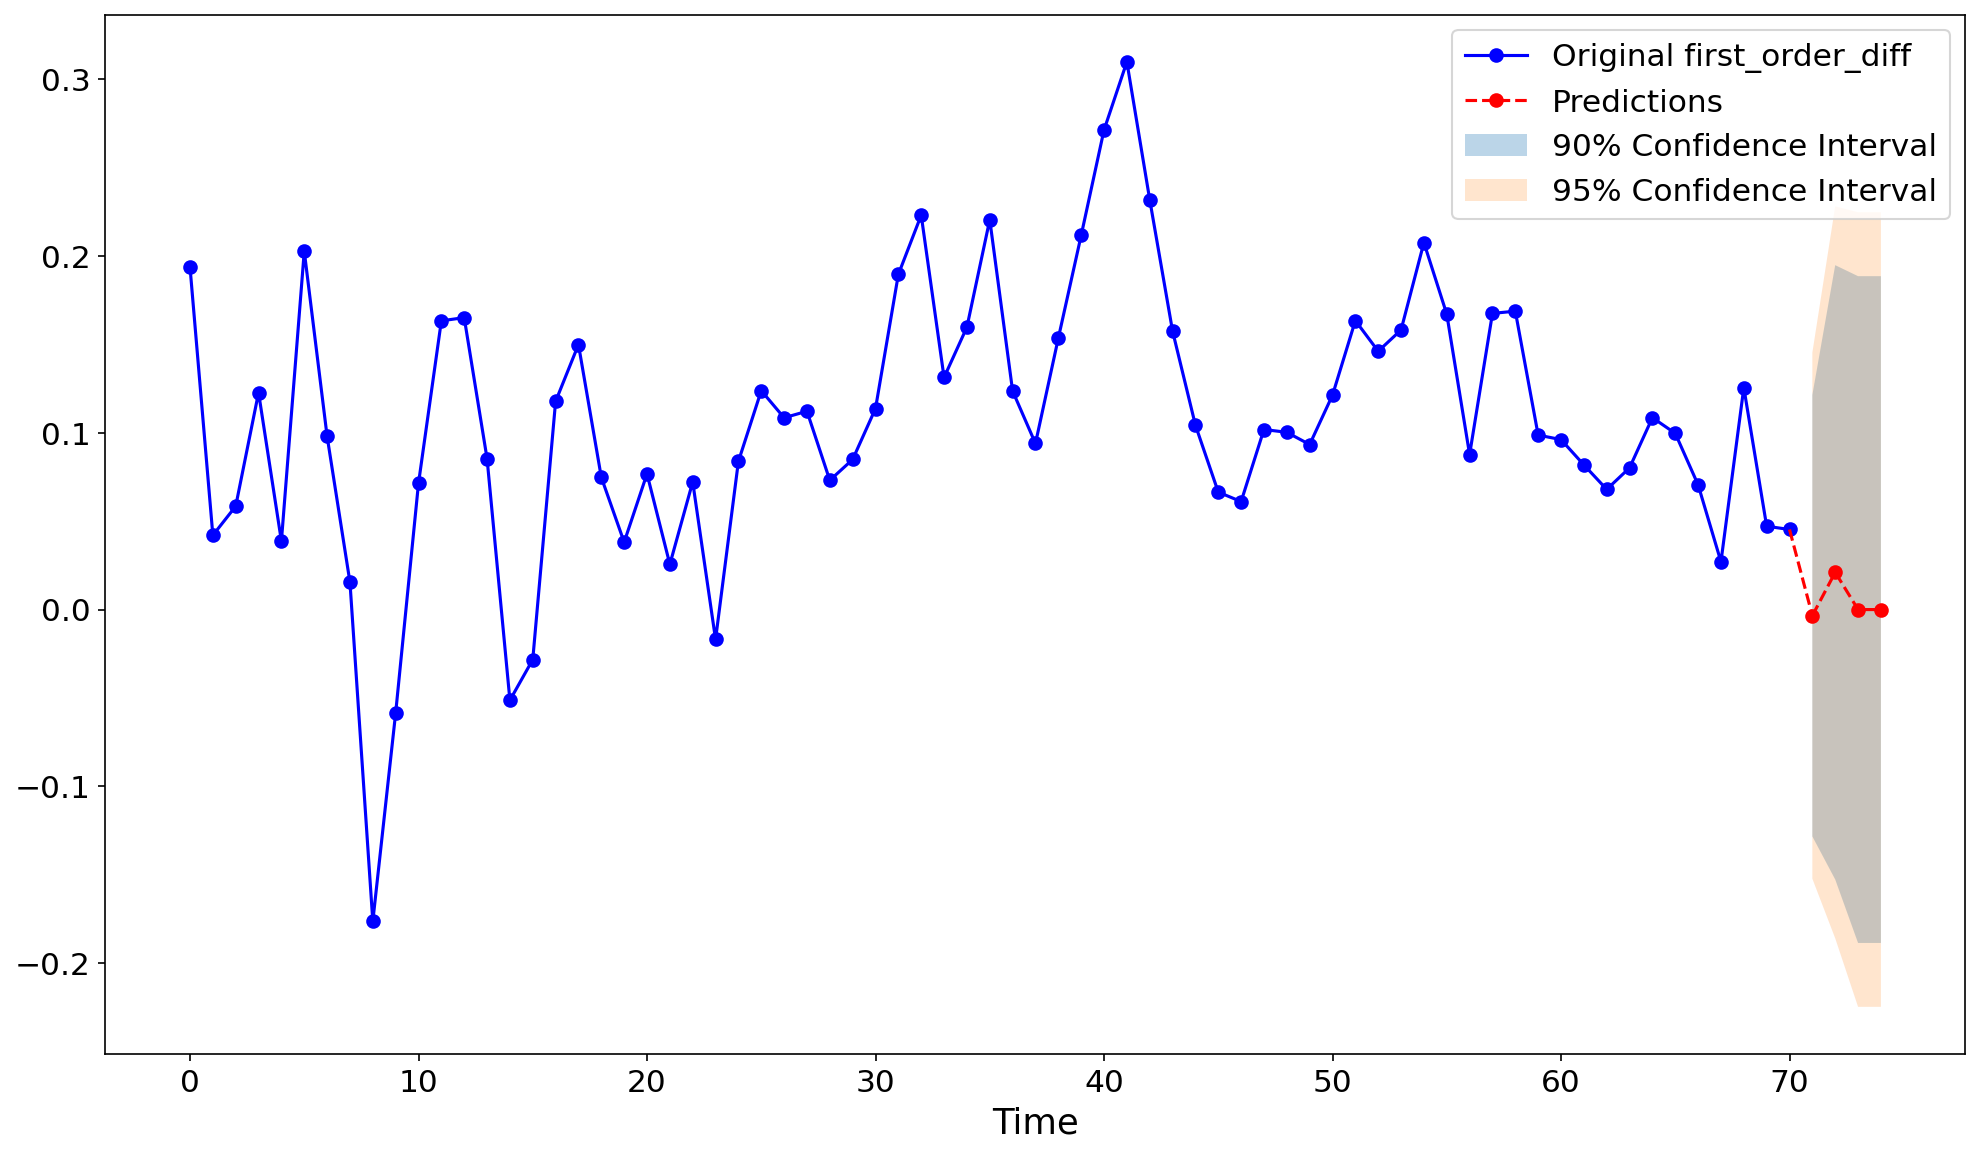

In [25]:
## 模型的预测
df_fore = res.get_forecast(steps=4)

confint1=df_fore.summary_frame(alpha=0.10)
confint2=df_fore.summary_frame(alpha=0.05).iloc[:,2:]
confint1.columns=["mean","mean_se","90%lower","90%upper"]
confint2.columns=["95%lower","95%upper"]
confint = pd.concat([confint1,confint2],axis=1,ignore_index=False)
print(confint)

plt.figure(figsize=(16, 9), dpi=150)
plt.plot(range(len(first_order_diff)), first_order_diff, linestyle='-', color='b', marker='o', markerfacecolor='b', label='Original first_order_diff')
plt.plot(range(len(first_order_diff), len(first_order_diff) + len(confint["mean"])), confint["mean"], linestyle='--', color='r', marker='o', markerfacecolor='r', label='Predictions')
plt.fill_between(range(len(first_order_diff), len(first_order_diff) + len(confint["mean"])), confint["90%lower"], confint["90%upper"], alpha=0.3, label='90% Confidence Interval')
plt.fill_between(range(len(first_order_diff), len(first_order_diff) + len(confint["mean"])), confint["95%lower"], confint["95%upper"], alpha=0.2, label='95% Confidence Interval')
last_data_index = len(first_order_diff) - 1
last_pred_index = len(first_order_diff)
plt.plot([last_data_index, last_pred_index], [first_order_diff[last_data_index], confint["mean"][last_pred_index-len(first_order_diff)]], linestyle='--', color='r')
plt.xlabel('Time', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig(fname='ARIMA一阶差分后预测结果.png')

## 九、模型的对比

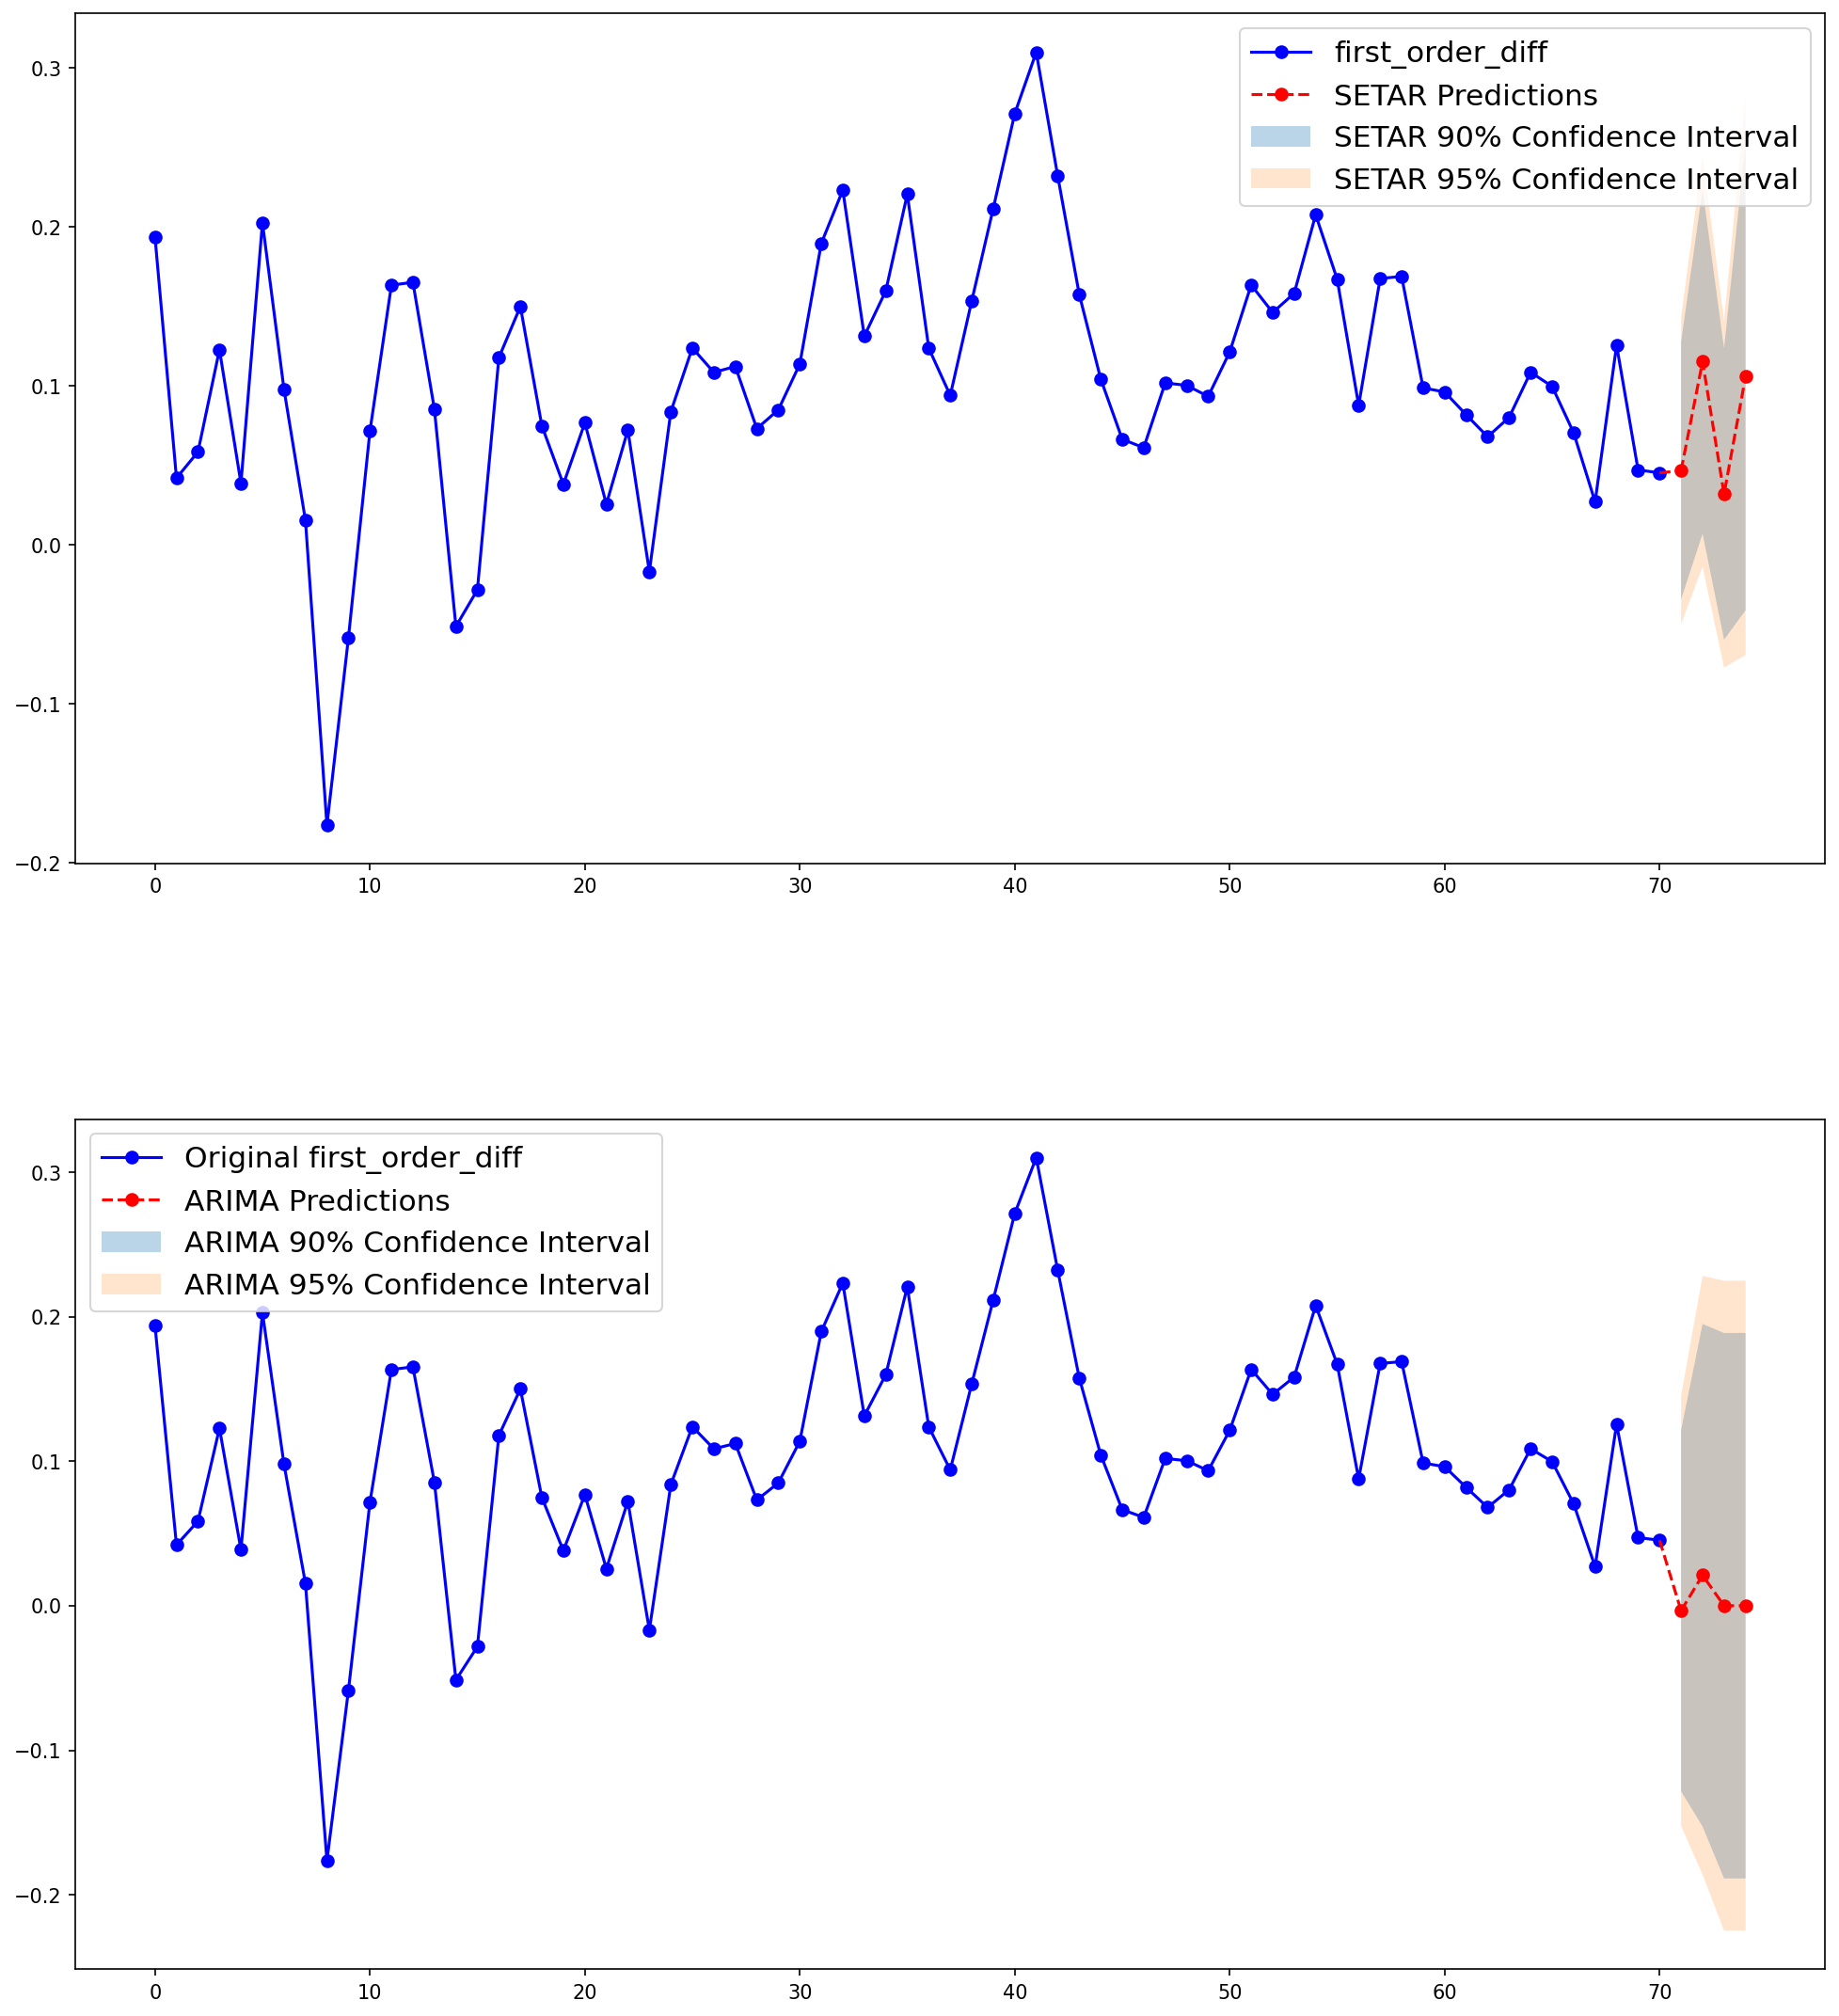

In [26]:
## SETAR与ARIMA预测结果对比
# 创建一个新的图形，用于绘制对比子图
fig, axes = plt.subplots(2, 1, figsize=(16, 18), dpi=150)

# 在第一个子图中绘制SETAR模型预测结果
ax1 = axes[0]
ax1.plot(range(len(first_order_diff)), first_order_diff, linestyle='-', color='b', marker='o', markerfacecolor='b', label='first_order_diff')
ax1.plot(range(len(first_order_diff), len(first_order_diff) + len(forecast_combined)), forecast_combined, linestyle='--', color='r', marker='o', markerfacecolor='r', label='SETAR Predictions')
ax1.fill_between(range(len(first_order_diff), len(first_order_diff) + len(forecast_combined)), forecast_combined_90_lower, forecast_combined_90_upper, alpha=0.3, label='SETAR 90% Confidence Interval')
ax1.fill_between(range(len(first_order_diff), len(first_order_diff) + len(forecast_combined)), forecast_combined_95_lower, forecast_combined_95_upper, alpha=0.2, label='SETAR 95% Confidence Interval')
last_data_index = len(first_order_diff) - 1
last_pred_index = len(first_order_diff)
ax1.plot([last_data_index, last_pred_index], [first_order_diff[last_data_index], forecast_combined[last_pred_index - len(first_order_diff)]], linestyle='--', color='r')
ax1.legend(fontsize=15)

# 在第二个子图中绘制ARIMA模型预测结果
ax2 = axes[1]
ax2.plot(range(len(first_order_diff)), first_order_diff, linestyle='-', color='b', marker='o', markerfacecolor='b', label='Original first_order_diff')
ax2.plot(range(len(first_order_diff), len(first_order_diff) + len(confint["mean"])), confint["mean"], linestyle='--', color='r', marker='o', markerfacecolor='r', label='ARIMA Predictions')
ax2.fill_between(range(len(first_order_diff), len(first_order_diff) + len(confint["mean"])), confint["90%lower"], confint["90%upper"], alpha=0.3, label='ARIMA 90% Confidence Interval')
ax2.fill_between(range(len(first_order_diff), len(first_order_diff) + len(confint["mean"])), confint["95%lower"], confint["95%upper"], alpha=0.2, label='ARIMA 95% Confidence Interval')
last_data_index = len(first_order_diff) - 1
last_pred_index = len(first_order_diff)
ax2.plot([last_data_index, last_pred_index], [first_order_diff[last_data_index], confint["mean"][last_pred_index - len(first_order_diff)]], linestyle='--', color='r')
ax2.legend(fontsize=15)

# 调整子图之间的间距
plt.subplots_adjust(hspace=0.3)

# 保存绘制好的对比图
plt.savefig(fname='SETAR与ARIMA预测结果对比.png')

对于这组差分数据的预测，直接通过两者预测图判断，预测效果$SETAR(2,4,1)$优于$ARIMA(0,0,2)$